# Causal Reasoning Evaluation 

{CRASS}: A Novel Data Set and Benchmark to Test Counterfactual Reasoning of Large Language Models


The CRASS benchmarks is a new test question set for the evaluation of the performance of large language models (LLMs) by utilizing so called questionized counterfactual conditionals (QCC).


In this study, this CR tasks are implemented by the following steps:

1. Collect all questions from the dataset and then formulate prompt tempelate with specific few-shot learning prompts.

| prompt_question                                                                                                                          | Answer | Evaluation_prompt | Evaluation_results |
|--------------------------------------------------------------------------------------------------------------------------------------------|--------|------------------|--------------------|
|You are a conscientious assistant, and you must answer my questions exactly as my questions require. <</SYS>> Please reference the following three examples (including premise, query, possible answers, and correct answer) to answer the final query. Premise: A feather falls from a skyscraper.  Query: What would have happened if a computer had fallen from the skyscraper?  Possible answers: The computer would have remained intact. That is not possible. The computer would have been crushed.  Correct answer: The computer would have been crushed. Premise: A lightning hits a tree.  Query: What would have happened if a marble would have hit the tree?  Possible answers: It would have burned down. Nothing special would have happened. The tree would have kissed the lightning.  Correct answer: Nothing special would have happened. Premise: A man drinks a beer.  Query: What would have happened if the man had drunk a rainbow?  Possible answers: It would have been tasty. It would have been awful. That is not possible.  Correct answer: That is not possible My premise: A woman finds the keys of a man. My query: What would have happened if the woman had lost the keys? The Possible answers: The man would have been angry with the woman.The man would not have been angry with the woman. Nothing special would have happened. What is the correct answer for my query? Just give me your answer without explanation and other words.|The correct answer is: The man would have been angry with the woman. |Based on the provided answer (if any) and the generated answer, respond to the following question with either "Yes" or "No". Your choice should be based on your judgment and the following rules: Yes: If the meanings of the two answers hold the same meaning, choose "Yes". No: If the meanings of the two answers are different, choose "No".\n\\Answer 1:\n"The man would have been angry with the woman."\n\\Answer 2:\n  The correct answer is: The man would have been angry with the woman.| 'Yes'


2. Then get the response from GPT models and calculate the accuracy score from ten times trials.
3. Finally, do the statistical analysis and causal modeling for future usage.


## Iterative Inference

In [ ]:
import pandas as pd
import time
from openai import OpenAI
from tqdm import tqdm
import os


def extract_final_response(response, prompt):
    return response[len(prompt) :]


def match_prompt_column(model):
    if "Llama-2" in model:
        return "llama2_chat_initial_prompt"
    elif "Mixtral" in model or "Mistral" in model:
        return "mixtral_instruct_initial_prompt"
    elif "Llama-3" in model:
        return "llama3_chat_initial_prompt"
    else:
        print("The model name didn't match anything, please check!!!!")
        return None


def extract_pure_response(row):
    model = row["model"]
    prompt_column = match_prompt_column(model)
    response = row["generated_response"]
    prompt = row[prompt_column]
    return extract_final_response(response=response, prompt=prompt)


def process_string(input_string):
    processed_string = input_string.strip("[]").replace("\\", "")
    questions = processed_string.split("\n")
    questions = [q.strip("'") for q in questions]
    return questions


SYS_MSG = """Based on the provided answer (if any) and the generated answer, respond to the following question with either "Yes" or "No". Your choice should be based on your judgment and the following rules: Yes: If the meanings of the two answers hold the same meaning, choose "Yes". No: If the meanings of the two answers are different, choose "No"."""
foler_path = "data/CR"
file_name = "exp_result_Mixtral-8x7B-Instruct-v0.1_20240601004917_953113.csv"
output_file_name = file_name.replace(".csv", "_evaluated.csv")
output_file_name_jsonl = file_name.replace(".csv", "_evaluated.jsonl")
input_path = os.path.join(foler_path, file_name)
output_path = os.path.join(foler_path, output_file_name)
output_path_jsonl = os.path.join(foler_path, output_file_name_jsonl)
_data = pd.read_csv(input_path)
eval_model = "gpt-3.5-turbo-0125"
api_key = os.getenv("OPENAI_API_KEY")

client = OpenAI(api_key=api_key)
temperature = 0
_data["pure_response"] = _data.apply(extract_pure_response, axis=1)

In [ ]:
if os.path.exists(output_path):
    print("Output path exists.")
    data_evaluated = pd.read_csv(output_path)
    last_idx = data_evaluated.shape[0]
else:
    print("Output path does not exist.")
    last_idx = 0

test_times = 0
times = 0
pbar = tqdm(total=len(_data))
for index, entry in tqdm(_data.iterrows()):
    if index <= last_idx:
        pbar.update(1)
        continue
    updated_row = entry.copy()
    correct_answer = entry["CorrectAnswer"]
    output = entry["pure_response"]
    if output is None:  # skip if result hasn't been generated
        continue
    message = []
    answer = ""
    content = f'{SYS_MSG}\n\Answer 1:\n"{correct_answer}"\n\Answer 2:\n{output}\n'
    message.append({"role": "user", "content": content})
    # create a chat completion
    success = False
    early_stop = False
    while not success:
        try:
            completion = client.chat.completions.create(
                model=eval_model,
                messages=message,
                temperature=temperature,
            )
            generation = completion.choices[0].message.content
            message.append({"role": "assistant", "content": generation})
            # check if generation is yes or no
            if generation.lower().startswith("yes") or generation.lower().startswith(
                "no"
            ):
                if generation.lower().startswith("yes"):
                    answer += "Yes\n"
                else:
                    answer += "No\n"
            else:
                if "YES" in generation and "NO" not in generation:
                    answer += "Yes\n"
                elif "YES" not in generation and "NO" in generation:
                    answer += "No\n"
                else:
                    for msg in message:
                        print(msg["content"])
                    print("NO YES or NO answer!" + generation)
                    answer += "None\n"
                    # early_stop = True Dont early stop
                    break
            success = True
        except Exception as e:
            print("ERROR!")
            print(e)
            print("Retry!")
            time.sleep(20)

    # when no answer occurs, break the loop and continue to next instance
    # if early_stop:
    #     break

    answer = answer[:-1]
    # save eval results as List[bool]
    bool_results = []
    for i in answer.split("\n"):
        if i == "Yes":
            bool_results.append(True)
        elif i == "No":
            bool_results.append(False)
        else:
            bool_results.append(None)

    updated_row["eval"] = bool_results
    updated_row["messages_openai"] = message
    test_times += 1
    updated_dataframe = pd.DataFrame([updated_row])
    pbar.update(1)
    if not os.path.exists(output_path):
        updated_dataframe.to_csv(output_path, index=False, mode="w", header=True)
    else:
        updated_dataframe.to_csv(output_path, index=False, mode="a", header=False)
    times = times + 1

# Batch inference API

In [ ]:
import pandas as pd
import time
from openai import OpenAI
from tqdm import tqdm
import os
import re
import string
from collections import Counter
import matplotlib.pyplot as plt


def str_to_bool(s):
    return s == "[True]"


def top1_accuracy_per_group(
    df, pctid_col="PCTID", temp_col="Temperature", pred_col="bool_eval"
):
    def top1_accuracy(group):
        correct = (group[pred_col]).sum()
        total = len(group)
        return correct / total

    accuracy_df = (
        df.groupby([pctid_col, temp_col, "model"])
        .apply(top1_accuracy)
        .reset_index(name="top1_accuracy")
    )
    return accuracy_df


foler_path = "data/CR"
output_file_name = file_name.replace(".csv", "_evaluated.csv")
input_path = os.path.join(foler_path, file_name)
output_path = os.path.join(foler_path, output_file_name)
df = pd.read_csv(output_path)
df["bool_eval"] = df["eval"].apply(str_to_bool)
accuracy_df = top1_accuracy_per_group(df)

In [ ]:
grouped_data = accuracy_df.groupby(["model", "Temperature"])["top1_accuracy"].mean()

models = accuracy_df["model"].unique()

plt.figure(figsize=(10, 6))
for model in models:
    model_data = grouped_data[model]
    plt.plot(
        model_data.index.get_level_values("Temperature"),
        model_data,
        marker="o",
        label=model,
    )

plt.xlabel("Temperature Scaling")
plt.ylabel("Rouge L fmeasure")
plt.title("Mean Rouge L fmeasure with Temperature Across Models\nTREC Dataset")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.legend(loc="center left", bbox_to_anchor=(1, 0.8))

plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.boxplot(x="Temperature", y="top1_accuracy", hue="model", data=accuracy_df)

plt.xlabel("Temperature Scaling")
plt.ylabel("Top-1 Accuracy")
plt.title("Top-1 Accuracy with Temperature Across Models")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.legend(loc="center left", bbox_to_anchor=(1, 0.8))

plt.show()

# Analysis ALL

In [1]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt

current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")
model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}

folder_path = "data/CR"
output_photo_name = f"CR_{current_time_str}.svg"
output_photo_path = os.path.join(folder_path, output_photo_name)
all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        df["weight_size"] = model_weight_sizes.get(model_name, None)
        all_dfs.append(df)

df = pd.concat(all_dfs, ignore_index=True)
df["Temperature"] = df["Temperature"].astype(float).round(1)

In [2]:
def string_to_boolean(s):
    s_stripped = s.strip("[]")
    return s_stripped.lower() == "true"


df["eval"] = df["eval"].apply(lambda x: string_to_boolean(x))
df["eval"] = df["eval"].apply(lambda x: 1 if x else 0)

Statistical results evaluation & validation

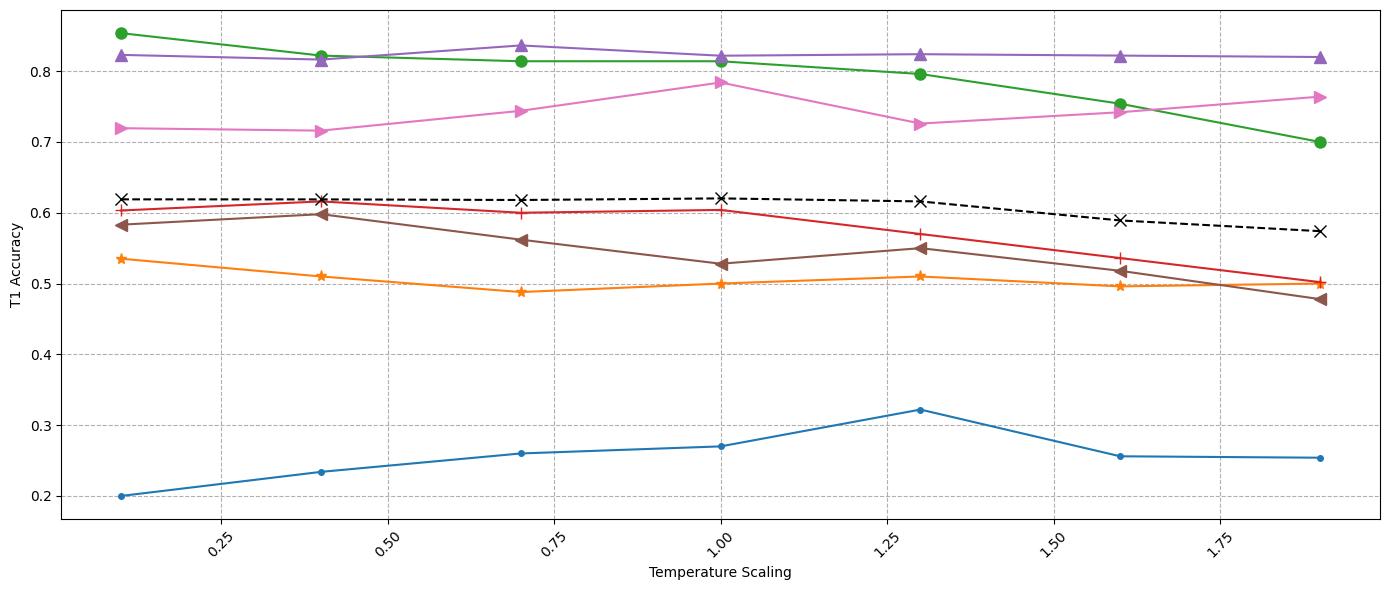

In [3]:
grouped_data = df.groupby(["model", "Temperature"])["eval"].mean()

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

markers = [
    ".",
    "*",
    "o",
    "+",
    "^",
    "<",
    ">",
    "8",
    "s",
    "p",
    ",",
    "v",
    "D",
    "d",
    "x",
    "|",
    "_",
]

plt.figure(figsize=(14, 6))
for i, model in enumerate(models):
    model_data = grouped_data[model]
    marker = markers[i % len(markers)]  # Select marker cyclically from the list
    plt.plot(
        model_data.index.get_level_values("Temperature"),
        model_data,
        marker=marker,
        markersize=8,
        label=model,
    )

grouped_data_temperature = df.groupby(["Temperature"])["eval"].mean()
plt.plot(
    grouped_data_temperature.index,
    grouped_data_temperature,
    linestyle="--",
    marker="x",
    markersize=8,
    color="black",
    label="Average Score Among All Models",
)

plt.xlabel("Temperature Scaling")
plt.ylabel("T1 Accuracy")
# plt.title("Caual Reasoning\n Mean T1 Accuracy with Temperature Across Models - CRASS")
plt.grid(
    linestyle="--",
)
plt.xticks(rotation=45)
plt.tight_layout()

# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.savefig(output_photo_path, format="svg", bbox_inches="tight")
# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [ ]:
from scipy.stats import kendalltau
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import pandas as pd


metric_name = "eval"

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

results = []
# Calculate the results for all the models
for model_name in models:
    model_data = df[df["model"] == model_name]
    temperatures = model_data["Temperature"].values
    # Normalised Accuracy Value So That The Accuracy Can Be comparable
    accuracy = model_data[metric_name].values
    accuracy = (accuracy - np.min(accuracy)) / (np.max(accuracy) - np.min(accuracy))
    # Calculate Correlation Metrics
    corr, p_value = spearmanr(temperatures, accuracy)
    temperatures = sm.add_constant(temperatures)
    model = sm.OLS(accuracy, temperatures).fit()
    predictions = model.predict(temperatures)
    se = np.sqrt(mean_squared_error(accuracy, predictions))
    r_squared = model.rsquared
    r_squared_adj = model.rsquared_adj
    beta_hat = model.params
    results.append(
        {
            "model": model_name,
            "beta+-SE": f"{beta_hat[1]:.3f} ± {se:.3f}",
            "r_squared": f"{r_squared:.3f}",
            "r_squared_adj": f"{r_squared_adj:.3f}",
            "Spearman correlation Coefficient": f"{corr:.3f}",
            "P_value": f"{p_value:.3f}",
            "se": f"{se:.3f}",
            "beta_hat_0": f"{beta_hat[0]:.3f}",
            "beta_hat_1": f"{beta_hat[1]:.3f}",
        }
    )


# The Calcluation for all the results accross the model
model_data = df
temperatures = model_data["Temperature"].values
accuracy = model_data[metric_name].values
accuracy = (accuracy - np.min(accuracy)) / (np.max(accuracy) - np.min(accuracy))
corr, p_value = spearmanr(temperatures, accuracy)
temperatures = sm.add_constant(temperatures)
model = sm.OLS(accuracy, temperatures).fit()
predictions = model.predict(temperatures)
se = np.sqrt(mean_squared_error(accuracy, predictions))
r_squared = model.rsquared
r_squared_adj = model.rsquared_adj
beta_hat = model.params
results.append(
    {
        "model": "All",
        "beta+-SE": f"{beta_hat[1]:.3f} ± {se:.3f}",
        "r_squared": f"{r_squared:.3f}",
        "r_squared_adj": f"{r_squared_adj:.3f}",
        "Spearman correlation Coefficient": f"{corr:.3f}",
        "P_value": f"{p_value:.3f}",
        "se": f"{se:.3f}",
        "beta_hat_0": f"{beta_hat[0]:.3f}",
        "beta_hat_1": f"{beta_hat[1]:.3f}",
    }
)


grouped_data = df.groupby(["Temperature"])[metric_name].mean().reset_index()

average_performance = grouped_data[metric_name].mean()

standard_deviation = grouped_data[metric_name].std()

range_value = grouped_data[metric_name].max() - grouped_data[metric_name].min()
statistical_range_percentage = (range_value / average_performance) * 100

coefficient_of_variation = (standard_deviation / average_performance) * 100

average_performance, standard_deviation, statistical_range_percentage, coefficient_of_variation

results_df = pd.DataFrame(results)
results_df

filtered_row = results_df[results_df["model"] == "All"]
spearman_coefficient = float(filtered_row["Spearman correlation Coefficient"].values[0])
p_value = float(filtered_row["P_value"].values[0])

print(f"Average Performance: {average_performance:.3f}")
print(f"Spearman correlation Coefficient: {spearman_coefficient:.3f}")
print(f"p_value: {p_value:.3f}")
# print(f"Standard Deviation: {standard_deviation:.3f}")
print(f"Range Percentage: {statistical_range_percentage:.3f}%")
print(f"Coefficient of Variation: {coefficient_of_variation:.3f}")

In [ ]:
from scipy.stats import kendalltau
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from scipy.stats import pearsonr

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

results = []
for model_name in models:
    model_data = df[df["model"] == model_name]
    temperatures = model_data["Temperature"].values
    accuracy = model_data["eval"].values
    corr, p_value = spearmanr(temperatures, accuracy)

    temperatures = sm.add_constant(temperatures)
    model = sm.OLS(accuracy, temperatures).fit()

    predictions = model.predict(temperatures)
    se = np.sqrt(mean_squared_error(accuracy, predictions))

    r_squared = model.rsquared
    r_squared_adj = model.rsquared_adj

    beta_hat = model.params
    results.append(
        {
            "model": model_name,
            "beta+-SE": f"{beta_hat[1]:.3f} ± {se:.3f}",
            "r_squared": f"{r_squared:.3f}",
            "r_squared_adj": f"{r_squared_adj:.3f}",
            "Spearman correlation Coefficient": f"{corr:.3f}",
            "P_value": f"{p_value:.3f}",
            "se": f"{se:.3f}",
            "beta_hat_0": f"{beta_hat[0]:.3f}",
            "beta_hat_1": f"{beta_hat[1]:.3f}",
        }
    )


results_df = pd.DataFrame(results)


# for model in models:
#     # print(f"Model: {model}")
#     print(f"{correlations[model]}")
# print()
# for model in models:
#     print(f"{p_values[model]}")

# for model in models:
#     print(f"Model: {model}")
#     print(f"Kendall correlation: {correlations[model]}")
#     print(f"p-value: {p_values[model]}")
#     print(f"OLS summary:")
#     print(ols_results[model].summary())
#     print()

results_df.to_csv("output.csv")